In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy import stats

In [2]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [3]:
import joblib
mt_pelatte = joblib.load('/home/qzeng/project/aging/231117_update_annot/AgingMajorType_Palette')

new_mt_palette = {}
for mt ,_color in mt_pelatte.items():
    mt= mt.replace('/','').replace(' ','_')
    new_mt_palette[mt] = _color

In [4]:
_gender = 'Male'
mc_type = 'CHN'

In [5]:
gene_name_to_id = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('/home/qzeng/project/aging/240112_DMG_CEF/gene_id_to_name_dict')

gene_meta_path = '/home/qzeng/project/aging/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col ='gene_id', sep='\t')
gene_meta['length'] = gene_meta['end'] - gene_meta['start']
gene_length_dict = gene_meta['length'].to_dict()

In [6]:
_dir = '/home/qzeng/project/aging/240112_DMG_CEF'
mc_all = pd.read_csv(f'{_dir}/result/{_gender}.{mc_type}.DMG.csv', index_col = 0)

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
mc_all['celltype'] = mc_all['celltype'].apply(lambda x: x.replace('/','').replace(' ','_'))

## select DEG

In [8]:
use_cts= joblib.load('mc_rna_corr_cts')
use_cts = [ct for ct in use_cts if ct.endswith('NN') == False]

In [9]:
_type = 'DEG'
pvalue_cutoff = 0.05
fc_cutoff = 0.1

In [10]:
result = {}
for ct in use_cts:
    rna_df = pd.read_csv(f"DEGs/{ct}.csv", index_col = 0)
    rna_df['log2(Aged/Young)'] = -rna_df['avg_log2FC']
    deg_df = rna_df[(rna_df['p_val_adj'] < pvalue_cutoff) & (abs(rna_df['log2(Aged/Young)']) > fc_cutoff)]
    
    # get DEG mc info
    mc_df  = mc_all[mc_all['celltype'] == ct].copy()
    mc_df['gene_name'] = mc_df.index.map(gene_id_to_name)

    deg_mc_df = mc_df.set_index('gene_name')
    deg_mc_df = deg_mc_df.loc[deg_mc_df.index.isin(deg_df.index)]
    deg_mc_df['Aged-Young'] = deg_mc_df['18mo'] - deg_mc_df['8wk']
    
    
    # also filter for DMGs
    deg_mc_df  = deg_mc_df[deg_mc_df['pvalue'] < 0.05]
    
    # filter duplicate genes
    unique_genes = deg_mc_df.index.value_counts()[deg_mc_df.index.value_counts() == 1].index
    deg_df = deg_df.loc[unique_genes]
    deg_mc_df = deg_mc_df.loc[unique_genes]
    
    to_plot = pd.concat([deg_df[['log2(Aged/Young)']], deg_mc_df[['Aged-Young']]], axis = 1)
    to_plot = to_plot.dropna()
    if to_plot.shape[0] >= 5:
        res = stats.pearsonr(to_plot['log2(Aged/Young)'], to_plot['Aged-Young'])
        result[ct] = res
    else:
        print(f"not enough {ct}")

not enough STR-PAL_Chst9_Gaba
not enough Lamp5_Gaba
not enough Sst_Gaba
not enough SUB-ProS_Glut
not enough Vip_Gaba
not enough Pvalb_Gaba
not enough MEA-BST_Gaba


In [11]:
all_corr = pd.DataFrame(result).T
all_corr.columns = ['corr','pvalue']
all_corr = all_corr.sort_values('corr')
all_corr['celltype'] = all_corr.index

In [12]:
# order by class
glut_cts = []
gaba_cts = []
nn_cts = []
for ct in all_corr.index:
    if ct.endswith('Glut'):glut_cts.append(ct)
    elif ct.endswith('Gaba'):gaba_cts.append(ct)
    elif ct.endswith('NN'):nn_cts.append(ct)

new_order = nn_cts+ glut_cts + gaba_cts
all_corr = all_corr.loc[new_order]

In [13]:
mean_corr = all_corr['corr'].mean()
mean_corr

-0.26062882994619035

In [15]:
mean_corr = round(mean_corr, 2)

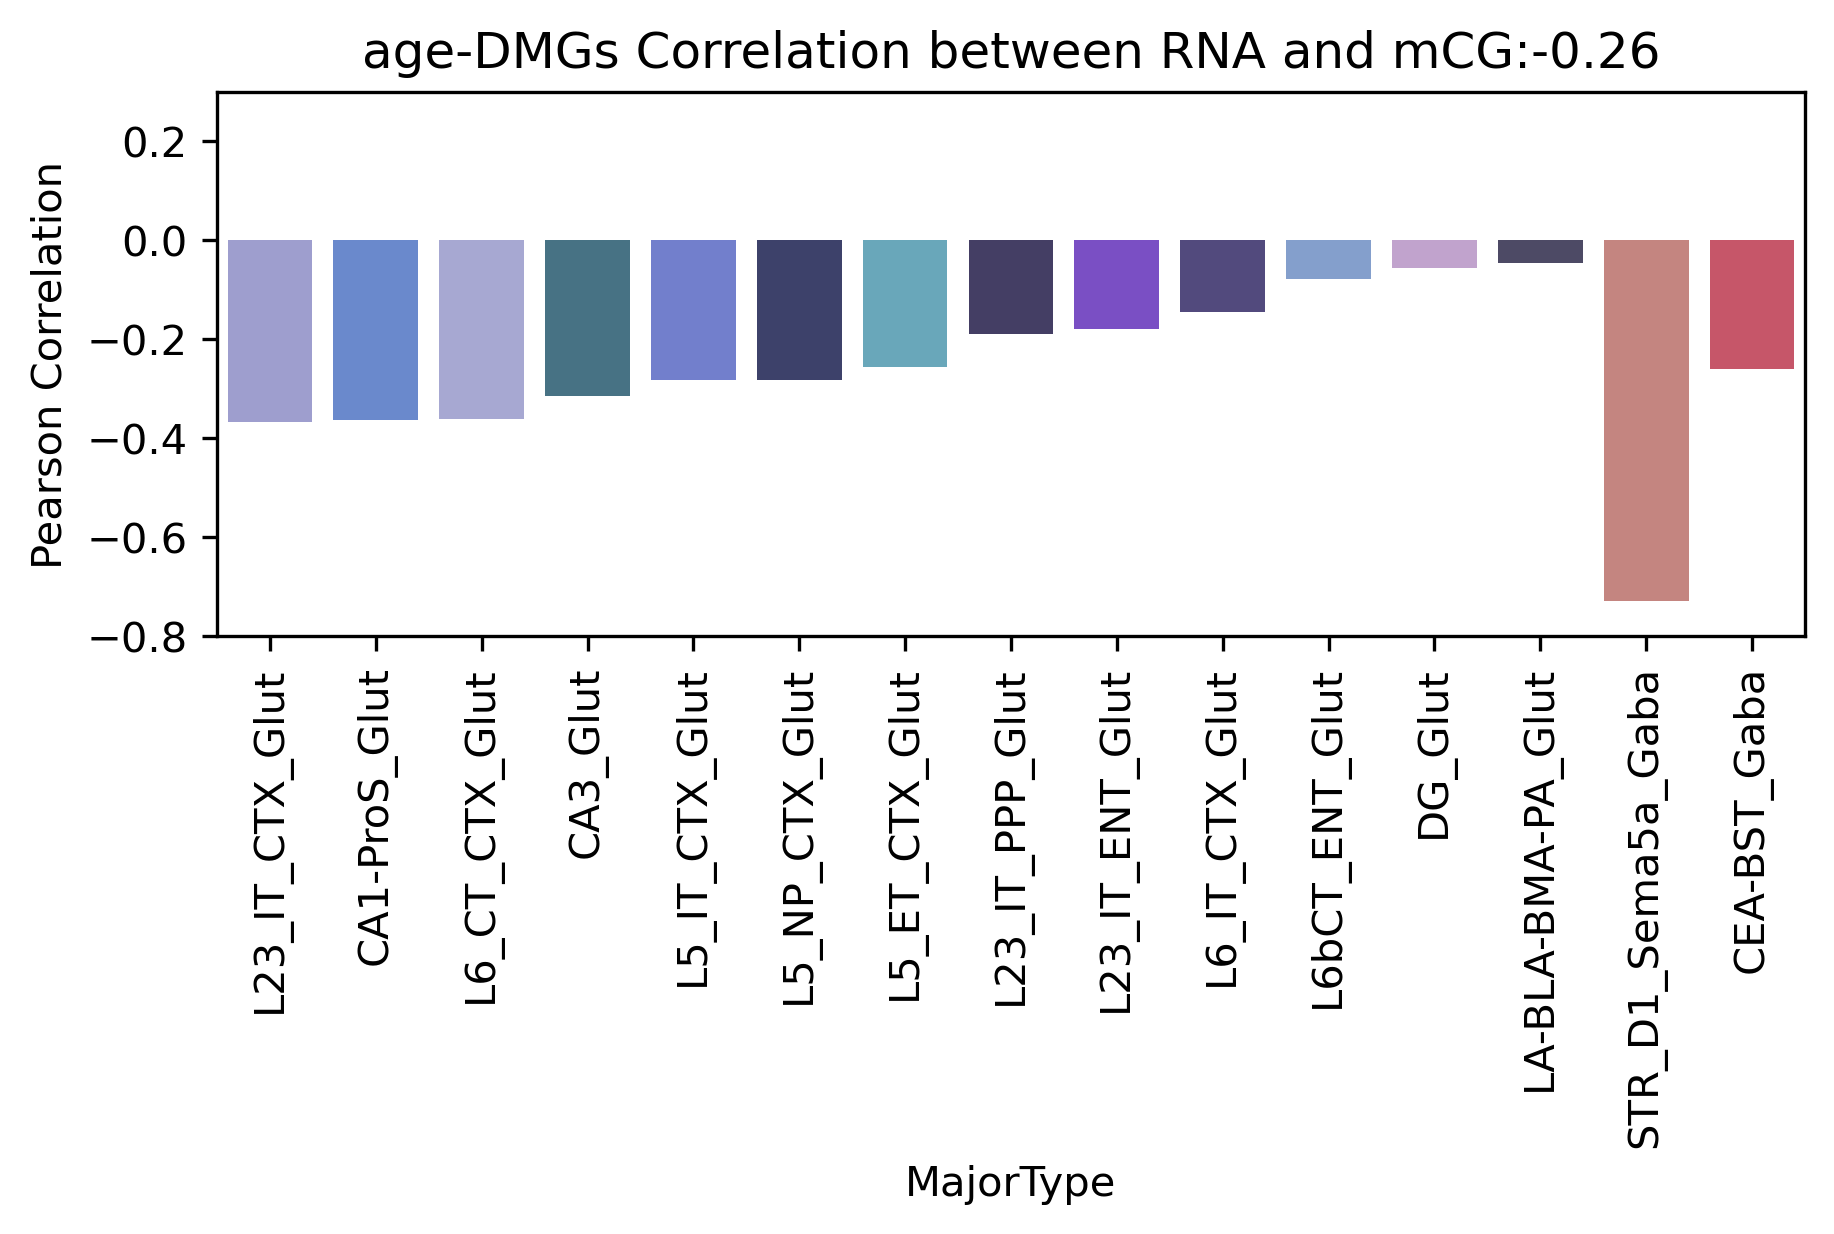

In [17]:
fig, ax =plt.subplots(figsize = (6,4), dpi = 300, constrained_layout = True)
sns.barplot(data = all_corr, 
            x="celltype", 
            y="corr", 
            hue="celltype", 
            palette = new_mt_palette,
            ax = ax,
            dodge=False,
            )

ax.legend_.remove()
#plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'age-DMGs Correlation between RNA and mCG:{mean_corr}')
plt.xlabel('MajorType')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=90)
ax.set_ylim(-0.8, 0.3)
fig.savefig(f'{mc_type}.aDMG.RNA_mC.Corr.pdf', bbox_inches = 'tight')
plt.show()